In [1]:
import argparse, pickle, os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpmath
import numpy as np
import pickle
import sys
sys.path.insert(1, '../')
from hyperparameter_correlation import plot_odr, adjust_measure, get_metric_bleu_df
from experiments_hyperparameters import EXPERIMENTS
from metrics import METRIC_FILES
from scipy import odr 

In [2]:
class parse:
    
    def __init__(self, metric='PL_alpha', bleu_type='id_bleu', group='lr', distribution='power_law', adjust_measures_back = True):
       
        self.metric = metric
        self.bleu_type = bleu_type
        self.group = group
        self.distribution = distribution
        self.adjust_measures_back = adjust_measures_back

### We can visualize the results for six different metrics.
### Choose one of the following.

In [3]:
## Choice 1: E_TPL_lambda
#args = parse(metric='E_TPL_lambda', group = 'sample')

## Choice 2: PL_alpha
#args = parse(metric='PL_alpha', group = 'sample')

## Choice 3: KS_distance for truncated powerlaw fitting
#args = parse(metric='E_TPL_KS_distance', group = 'sample', distribution='truncated_power_law')

## Choice 4: stable rank
#args = parse(metric='stable_rank', group = 'sample')

## Choice 5: stable rank
#args = parse(metric='PL_KS_distance', group = 'sample', distribution='power_law')

## Choice 6: mp softrank
args = parse(metric='mp_softrank', group = 'sample', distribution='power_law')

In [ ]:
assert args.metric in METRIC_FILES.keys()
assert args.bleu_type in ["id_bleu", "ood_bleu", "id_bleu_gap", "id_bleu_train", "id_loss_gap", "id_loss_train", "id_loss_val"]
assert args.group in ["sample", "depth", "lr"]
assert args.distribution in ["power_law", "truncated_power_law"]

## Construct a DataFrame of length num_experiments
## The columns are [id_bleu, ood_bleu, metric, sample, depth, lr, dropout]
records = []
for experiment in EXPERIMENTS["WMT14_depth"]:
    metric_bleu_df = get_metric_bleu_df(experiment, args.distribution, args.adjust_measures_back, args.metric)
    # Get the last three epochs' BLEU/metric
    average_length = 3
    record = {
        'id_bleu': sum([metric_bleu_df.iloc[-x]['id_bleu'] for x in range(1,1+average_length)])/average_length,
        'id_bleu_train': sum([metric_bleu_df.iloc[-x]['id_bleu_train'] for x in range(1,1+average_length)])/average_length,
        'id_bleu_gap': sum([metric_bleu_df.iloc[-x]['id_bleu_gap'] for x in range(1,1+average_length)])/average_length,
        'id_loss_gap': sum([metric_bleu_df.iloc[-x]['id_loss_gap'] for x in range(1,1+average_length)])/average_length,
        'id_loss_train': sum([metric_bleu_df.iloc[-x]['id_loss_train'] for x in range(1,1+average_length)])/average_length,
        'id_loss_val': sum([metric_bleu_df.iloc[-x]['id_loss_val'] for x in range(1,1+average_length)])/average_length,
        'ood_bleu': sum([metric_bleu_df.iloc[-x]['ood_bleu'] for x in range(1,1+average_length)])/average_length,
        f'{args.metric}': sum([metric_bleu_df.iloc[-x][f'{args.metric}'] for x in range(1,1+average_length)])/average_length,
        'sample': re.search("sample(\d+)", experiment).group(1),
        'depth': re.search("depth(\d+)", experiment).group(1),
        'lr': re.search("lr([\d.]+)", experiment).group(1),
        'dropout': re.search("dropout([\d.]+)", experiment).group(1),
    }
    records.append(record)

df = pd.DataFrame.from_records(records)

# Plot figures with linear regression

[None, None]

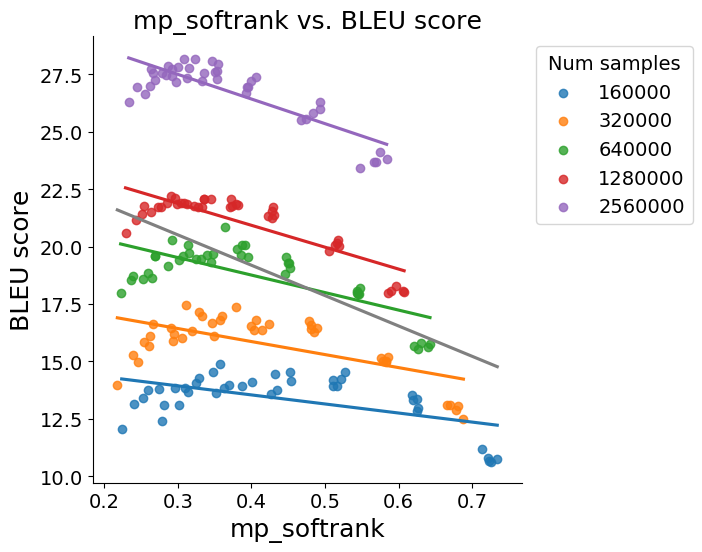

In [5]:
plot_metric_name = args.metric.lower()

plot_bleu_type_name = args.bleu_type
if plot_bleu_type_name == 'id_bleu':
    plot_bleu_type_name = 'BLEU score'

plot_group_name = args.group
if plot_group_name == 'lr':
    plot_group_name = 'Learning rate'
if plot_group_name == 'sample':
    plot_group_name = 'Num samples'

# Simpson's scatterplot
lm = sns.lmplot(
    data=df,
    x=f'{args.metric}',
    y=f'{args.bleu_type}',
    hue=f'{args.group}',
    fit_reg=True,
    ci=None,
    legend=False,
)
ax = lm.axes[0, 0]
sns.regplot(
    data=df,
    x=f'{args.metric}',
    y=f'{args.bleu_type}',
    scatter=False,
    fit_reg=True,
    ci=None,
    color='gray',
)    
ax.set_xlabel(plot_metric_name, fontsize=18)
ax.set_ylabel(plot_bleu_type_name, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_title(f"{plot_metric_name} vs. {plot_bleu_type_name}", fontsize=18)
legend = plt.legend(title=plot_group_name, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=14)
plt.setp(legend.get_title(),fontsize=14)

# Plot figures with ODR

In [6]:
def f(B, x):
    return B[0]*x + B[1]
linear = odr.Model(f)

[None, None]

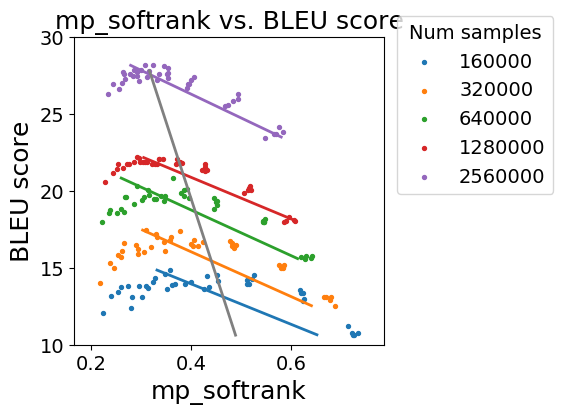

In [7]:
fig, ax = plt.subplots(figsize=(4,4))

for group_value in df[args.group].unique():
        
    subgroup = df.loc[df[args.group] == group_value]
    y = subgroup[args.bleu_type].values
    x = subgroup[args.metric].values
    ax.scatter(x,y,s=8, label=group_value)
    plot_odr(x,y,ax)
    
y = df[args.bleu_type].values
x = df[args.metric].values
plot_odr(x,y,ax,color='gray')

xmin, xmax = df[args.metric].min(), df[args.metric].max()

ax.set_xlabel(plot_metric_name, fontsize=18)
ax.set_ylabel(plot_bleu_type_name, fontsize=18)
ax.set_ylim([10,30])
ax.set_xlim([xmin-(xmax-xmin)*0.1,xmax+(xmax-xmin)*0.1])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_title(f"{plot_metric_name} vs. {plot_bleu_type_name}", fontsize=18)
legend = plt.legend(title=plot_group_name, bbox_to_anchor=(1.01, 1.1), loc='upper left', fontsize=14)
plt.setp(legend.get_title(),fontsize=14)

# Use polynomial fitting to get the best point in each group

In [8]:
def plot_odr_polynomial(x,y,ax,color='',order=3):
    
    data = odr.Data(x, y)
    poly_model = odr.polynomial(order)
    
    ordinal_distance_reg = odr.ODR(data, poly_model)
    ordinal_distance_reg.set_job(fit_type=2)
    out = ordinal_distance_reg.run()

    xx = np.linspace(min(x),max(x),100)
    poly = np.poly1d(out.beta[::-1])
    poly_y = poly(xx)
    
    max_ind = np.argmax(poly_y)
    
    if color:
        ax.plot(xx,poly_y,color=color)
    else:
        ax.plot(xx,poly_y)
    
    return xx[max_ind], poly_y[max_ind], min(x), min(y), max(x), max(y)

160000
320000
640000
1280000
2560000


[None, None]

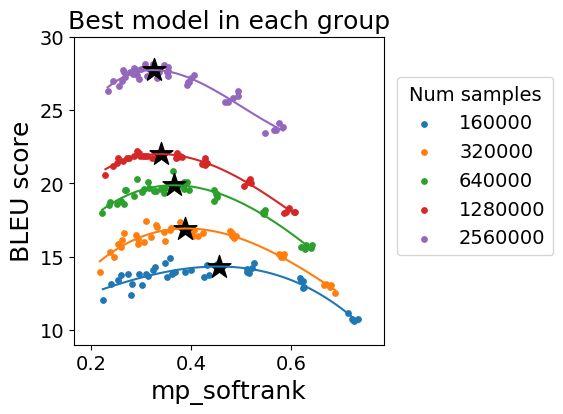

In [9]:
fig, ax = plt.subplots(figsize=(4,4))

best_xx = []
best_yy = []
xxmin, xxmax = 10000, 0
yymin, yymax = 10000, 0

group_values = df[args.group].unique()
group_values = sorted(group_values, key = int)

for group_value in group_values:
        
    subgroup = df.loc[(df[args.group] == group_value) & (df['lr']!= '2.0') & (df['lr']!= '1.5')]
    y = subgroup[args.bleu_type].values
    x = subgroup[args.metric].values
    print(group_value)
    ax.scatter(x,y,s=15, label=group_value)
    best_x, best_y, minx, miny, maxx, maxy = plot_odr_polynomial(x,y,ax)
    best_xx.append(best_x)
    best_yy.append(best_y)
    xxmin = min(xxmin, minx)
    yymin = min(yymin, miny)
    xxmax = max(xxmax, maxx)
    yymax = max(yymax, maxy)

ax.scatter(best_xx, best_yy, s=300, marker="*", color='black')
ax.set_xlabel(plot_metric_name, fontsize=18)
ax.set_ylabel(plot_bleu_type_name, fontsize=18)
ax.set_ylim([9,30])
ax.set_xlim([xxmin-(xxmax-xxmin)*0.1,xxmax+(xxmax-xxmin)*0.1])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_title("Best model in each group", fontsize=18)
legend = plt.legend(title=plot_group_name, bbox_to_anchor=(1.01, 0.9), loc='upper left', fontsize=14)
plt.setp(legend.get_title(),fontsize=14)